In [3]:
import os
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

,de,en
0,An der B 211 befindet sich in Loyermoor der so...,Here the largest town of the district is locat...
1,Ich begrüße die Erklärung des Herrn Kommissar ...,"I should like, in passing, to pay tribute to t..."
2,"Das ist das Gegenteil von dem, was getan werde...",That is the opposite of what should be done an...
3,.,.
4,The Ethnographical museum in Varna is in a hou...,It was designed by the Viennese architect Rupp...


Dataset size: (4508785, 2)
Missing values:
de    0
en    0
dtype: int64


/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


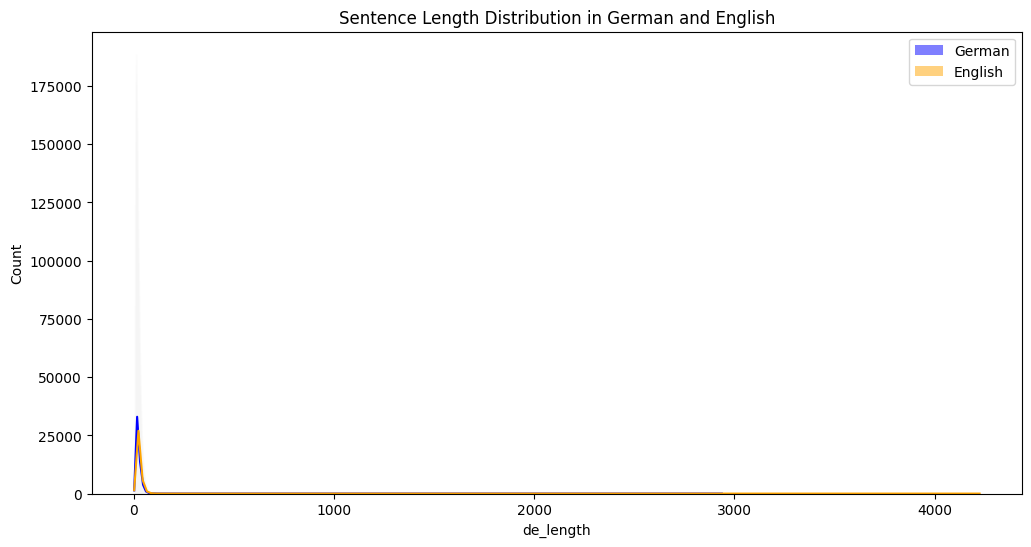

In [33]:
dataset = pd.read_csv('../data/wmt14_translate_de-en_train.csv', lineterminator='\n')

# Explore the dataset
display(dataset.head())
print(f'Dataset size: {dataset.shape}')
print(f'Missing values:\n{dataset.isnull().sum()}')

dataset.describe()

# Plot length of sentences in German and English
dataset['de_length'] = dataset['de'].apply(lambda x: len(x.split()))
dataset['en_length'] = dataset['en'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(dataset['de_length'], color="blue", label="German", kde=True)
sns.histplot(dataset['en_length'], color="orange", label="English", kde=True)
plt.legend()
plt.title('Sentence Length Distribution in German and English')
plt.show()


In [4]:
train_raw = pd.read_csv('../data/wmt14_translate_de-en_train.csv', lineterminator='\n', nrows=45000)
test_raw = pd.read_csv('../data/wmt14_translate_de-en_test.csv', lineterminator='\n')
val_raw = pd.read_csv('../data/wmt14_translate_de-en_validation.csv', lineterminator='\n')

In [5]:
train_raw.shape

(45000, 2)

In [7]:
train_raw.head()

,de,en
0,An der B 211 befindet sich in Loyermoor der so...,Here the largest town of the district is locat...
1,Ich begrüße die Erklärung des Herrn Kommissar ...,"I should like, in passing, to pay tribute to t..."
2,"Das ist das Gegenteil von dem, was getan werde...",That is the opposite of what should be done an...
3,.,.
4,The Ethnographical museum in Varna is in a hou...,It was designed by the Viennese architect Rupp...


In [8]:
# Function to clean the text data (e.g., lowercasing, removing special characters)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

# Clean both German and English text
train_raw['de'] = train_raw['de'].apply(clean_text)
train_raw['en'] = train_raw['en'].apply(clean_text)
val_raw['de'] = val_raw['de'].apply(clean_text)
val_raw['en'] = val_raw['en'].apply(clean_text)
test_raw['de'] = test_raw['de'].apply(clean_text)
test_raw['en'] = test_raw['en'].apply(clean_text)

# Tokenization and padding
def tokenize_and_pad(texts, max_len=30):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences, tokenizer

# Prepare German and English tokenizers and sequences
max_len = 30  # Set a suitable max length for padding
train_de_sequences, de_tokenizer = tokenize_and_pad(train_raw['de'], max_len)
train_en_sequences, en_tokenizer = tokenize_and_pad(train_raw['en'], max_len)
val_de_sequences, _ = tokenize_and_pad(val_raw['de'], max_len)
val_en_sequences, _ = tokenize_and_pad(val_raw['en'], max_len)
test_de_sequences, _ = tokenize_and_pad(test_raw['de'], max_len)
test_en_sequences, _ = tokenize_and_pad(test_raw['en'], max_len)

# Vocabulary sizes
de_vocab_size = len(de_tokenizer.word_index) + 1  # Add 1 for padding token
en_vocab_size = len(en_tokenizer.word_index) + 1  # Add 1 for padding token 

print(f'German vocabulary size: {de_vocab_size}')
print(f'English vocabulary size: {en_vocab_size}')

German vocabulary size: 98873
English vocabulary size: 57214


In [9]:
# Encoder Class
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_state=True)
    
    def call(self, inputs):
        x = self.embedding(inputs)
        output, state_h, state_c = self.lstm(x)
        return output, state_h, state_c


# Decoder Class with Attention Mechanism
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
        self.attention = Attention()
        self.dense = TimeDistributed(Dense(vocab_size, activation='softmax'))

    def call(self, inputs, context_vector, initial_state):
        x = self.embedding(inputs)
        lstm_output, _, _ = self.lstm(x, initial_state=initial_state)
        attention_output = self.attention([lstm_output, context_vector])
        decoder_concat_input = Concatenate()([lstm_output, attention_output])
        output = self.dense(decoder_concat_input)
        return output

In [10]:
def build_model(en_vocab_size, de_vocab_size, embedding_dim, hidden_units, max_len):
    # Encoder
    encoder_input = Input(shape=(max_len,), name='encoder_input')
    encoder_emb = Embedding(en_vocab_size, embedding_dim, input_length=max_len)(encoder_input)
    encoder_lstm = LSTM(hidden_units, return_state=True, dropout=0.5)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_input = Input(shape=(max_len - 1,), name='decoder_input')  # Shifted by 1
    decoder_emb = Embedding(de_vocab_size, embedding_dim, input_length=max_len-1)(decoder_input)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, dropout=0.5)
    decoder_lstm_out, _, _ = decoder_lstm(decoder_emb, initial_state=encoder_states)
    
    decoder_dense = Dense(de_vocab_size, activation='softmax')
    decoder_output = decoder_dense(decoder_lstm_out)
    
    model = Model([encoder_input, decoder_input], decoder_output)
    
    return model

embedding_dim = 256
lstm_units = 512

model = build_model(en_vocab_size, de_vocab_size, embedding_dim, lstm_units, max_len)

# Print model summary
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-08 16:47:43.075706: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 256)   │ 14,646,784 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 29, 256)   │ 25,311,488 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 29, 512), │  1,574,912 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 29, 98873) │ 50,721,849 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,829,945 (357.93 MB)

 Trainable params: 93,829,945 (357.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_en_sequences = pad_sequences(train_en_sequences, maxlen=max_len, padding='post')
train_de_sequences = pad_sequences(train_de_sequences, maxlen=max_len, padding='post')

# Decoder input and output (padded to match sequence length)
decoder_input = train_de_sequences[:, :-1]  # Shifted German sequence
decoder_output = np.expand_dims(train_de_sequences[:, 1:], -1)  # Shifted German sequence

# Train the model (do not redefine the model here)
history = model.fit(
    [train_en_sequences, decoder_input],  # Encoder input: English, Decoder input: padded shifted German
    decoder_output,                             # Decoder target: padded shifted German
    epochs=30, 
    batch_size=64, 
    validation_data=([val_en_sequences, val_de_sequences[:, :-1]], np.expand_dims(val_de_sequences[:, 1:], -1))
)

# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()


Epoch 1/30


/home/shurtu-gal/Stuff/neural-machine-translation/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


  1/704 ━━━━━━━━━━━━━━━━━━━━ 6:53:58 35s/step - accuracy: 0.0000e+00 - loss: 11.5007